In [31]:
# Import Library yang Diperlukan
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from skimage.feature import hog
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Pengaturan Path dan Membaca Dataset
dataset_path = '/content/drive/MyDrive/katarak/dataset'  # Ganti dengan path dataset Anda
categories = ['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']

# Membaca gambar dan menyimpan informasi dalam DataFrame
data = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for img in os.listdir(category_path):
        img_path = os.path.join(category_path, img)
        data.append((img_path, category))

df = pd.DataFrame(data, columns=['image_path', 'label'])

In [4]:
# Data Cleaning
def check_image_validity(img_path):
    try:
        img = Image.open(img_path)
        img.verify()  # Memeriksa apakah gambar valid
        return True
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return False

df['valid'] = df['image_path'].apply(check_image_validity)
df_cleaned = df[df['valid']]

In [5]:
# Data Manipulasi
summary_table = df_cleaned['label'].value_counts().reset_index()
summary_table.columns = ['label', 'count']
print(summary_table)
print("Total images:", len(df_cleaned))

                  label  count
0  diabetic_retinopathy   1098
1                normal   1074
2              cataract   1038
3              glaucoma   1007
Total images: 4217


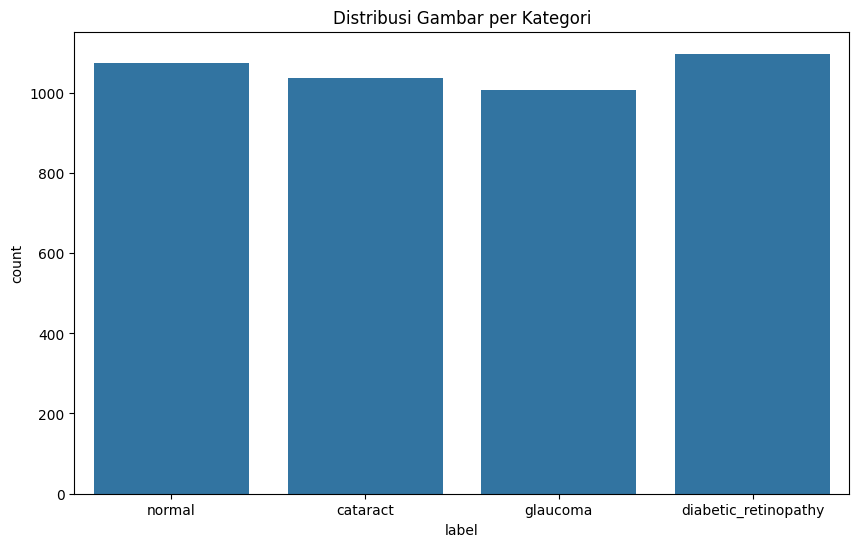

In [6]:
# Visualisasi Data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='label')
plt.title('Distribusi Gambar per Kategori')
plt.show()

In [7]:
# Data Augmentasi
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
# Ekstraksi Fitur
def extract_hog_features(img_path):
    img = Image.open(img_path).convert('L')  # Konversi ke grayscale
    img = img.resize((128, 128))  # Ubah ukuran gambar
    img_array = np.array(img)
    features, hog_image = hog(img_array, visualize=True)
    return features

df_cleaned['features'] = df_cleaned['image_path'].apply(extract_hog_features)

print("Mean and standard deviation of features:\n", df_cleaned['features'].apply(lambda x: np.mean(x)).describe())

Mean and standard deviation of features:
 count    4217.000000
mean        0.071911
std         0.009694
min         0.041995
25%         0.067450
50%         0.073701
75%         0.078632
max         0.094370
Name: features, dtype: float64


In [9]:
# Persiapan Data untuk Model
X = np.array(df_cleaned['features'].tolist())
y = df_cleaned['label'].values

# One-hot encoding
lb = LabelBinarizer()
y = lb.fit_transform(y)

# Membagi data menjadi data pelatihan dan pengujian
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Membangun Model untuk Fitur HOG
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))  # Input shape sesuai dengan jumlah fitur HOG
model.add(Dropout(0.5))  # Dropout untuk mengurangi overfitting
model.add(Dense(len(categories), activation='softmax'))  # Output layer dengan softmax untuk klasifikasi multi-kelas

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │       2,032,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,032,772 (7.75 MB)

 Trainable params: 2,032,772 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Melatih Model dengan Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_hog.keras', save_best_only=True)

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5360 - loss: 1.0361 - val_accuracy: 0.7405 - val_loss: 0.5857
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7232 - loss: 0.6386 - val_accuracy: 0.8021 - val_loss: 0.5333
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7759 - loss: 0.5480 - val_accuracy: 0.7891 - val_loss: 0.4967
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7963 - loss: 0.4804 - val_accuracy: 0.8294 - val_loss: 0.4602
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8101 - loss: 0.4536 - val_accuracy: 0.8270 - val_loss: 0.4425
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8264 - loss: 0.4134 - val_accuracy: 0.8495 - val_loss: 0.4142
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8376 - loss: 0.3957 - val_accuracy: 0.8507 - val_loss: 0.3972
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8301 - loss: 0.3870 - val_accu

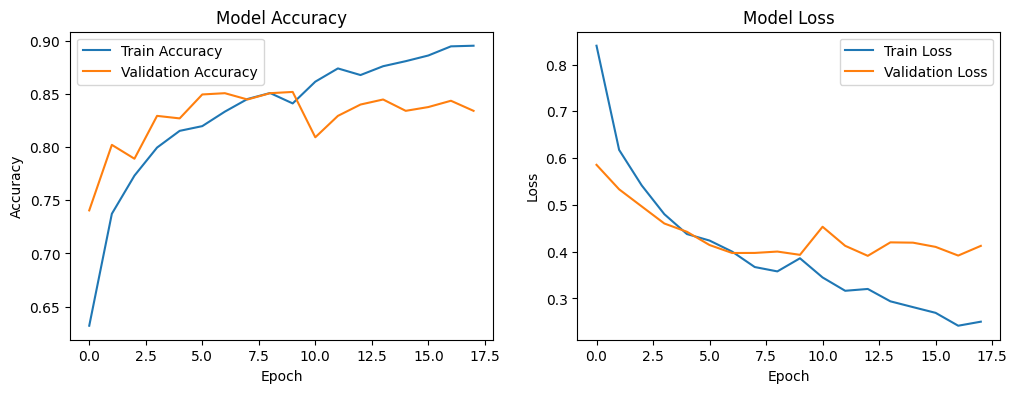

In [12]:
# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Classification Report:
                       precision    recall  f1-score   support

            cataract       0.86      0.81      0.83       203
diabetic_retinopathy       0.98      1.00      0.99       203
            glaucoma       0.69      0.77      0.73       193
              normal       0.84      0.80      0.82       245

            accuracy                           0.84       844
           macro avg       0.84      0.84      0.84       844
        weighted avg       0.84      0.84      0.84       844



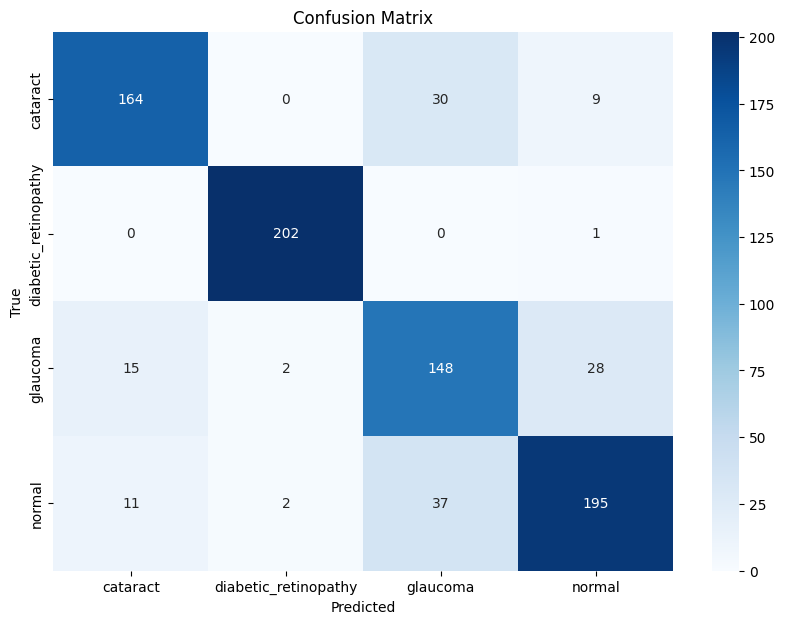

In [14]:
# Evaluasi Model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Analisis Hasil
def analyze_results(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=lb.classes_)
    print("Classification Report:\n", report)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Analisis hasil
analyze_results(y_true_classes, y_pred_classes)

In [16]:
# Prediksi probabilitas
y_pred_proba_nn = model.predict(X_val)

# Hitung AUC (One-vs-Rest)
auc_nn = roc_auc_score(y_val, y_pred_proba_nn, multi_class='ovr')
print(f"AUC for Neural Network: {auc_nn}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
AUC for Neural Network: 0.9663360794454963


In [ ]:
# Pengujian Model dengan Gambar Baru
def predict_image(image_path):
    try:
        img = Image.open(image_path).resize((128, 128))
        img_array = np.array(img).reshape(1, 128, 128, 3) / 255.0
        prediction = model.predict(img_array)
        class_index = np.argmax(prediction)
        return lb.classes_[class_index]
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None

# Contoh penggunaan
test_image_path = 'path/to/test/image.jpg'  # Ganti dengan path gambar yang ingin diuji
predicted_class = predict_image(test_image_path)
print(f'Predicted class for the test image: {predicted_class}')

In [17]:
# Membuat model SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

In [18]:
# Membuat model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [19]:
# Mengubah y kembali ke bentuk satu dimensi
y_train_1d = np.argmax(y_train, axis=1)
y_val_1d = np.argmax(y_val, axis=1)

In [20]:
# Melatih model Random Forest
rf_model.fit(X_train, y_train_1d)

RandomForestClassifier(random_state=42)

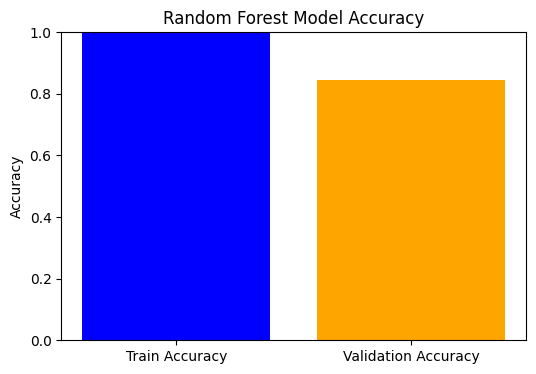

In [23]:
# Memprediksi pada data pelatihan dan validasi
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

# Menghitung akurasi
train_accuracy_rf = accuracy_score(y_train_1d, y_train_pred_rf)
val_accuracy_rf = accuracy_score(y_val_1d, y_val_pred_rf)

# Visualisasi akurasi
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_accuracy_rf, val_accuracy_rf], color=['blue', 'orange'])
plt.title('Random Forest Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

Random Forest Classification Report:
                       precision    recall  f1-score   support

            cataract       0.85      0.79      0.82       203
diabetic_retinopathy       0.98      1.00      0.99       203
            glaucoma       0.76      0.66      0.71       193
              normal       0.80      0.91      0.85       245

            accuracy                           0.84       844
           macro avg       0.84      0.84      0.84       844
        weighted avg       0.84      0.84      0.84       844



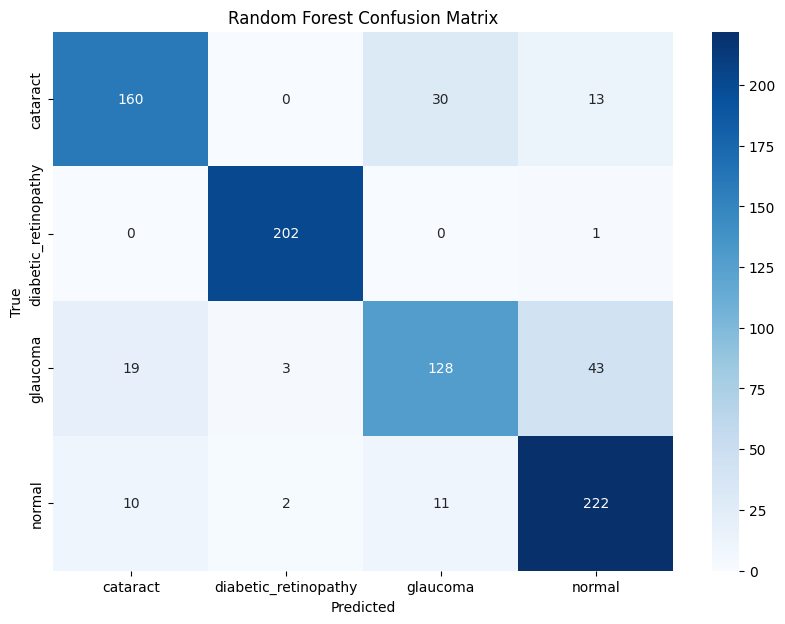

In [24]:
# Menghitung classification report
print("Random Forest Classification Report:\n", classification_report(y_val_1d, y_val_pred_rf, target_names=lb.classes_))

# Menghitung confusion matrix
cm_rf = confusion_matrix(y_val_1d, y_val_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [25]:
# Prediksi probabilitas
y_pred_proba_rf = rf_model.predict_proba(X_val)

# Hitung AUC (One-vs-Rest)
auc_rf = roc_auc_score(y_val_1d, y_pred_proba_rf, multi_class='ovr')
print(f"AUC for Random Forest: {auc_rf}")

AUC for Random Forest: 0.955075800844402


In [26]:
# Melatih model SVM
svm_model.fit(X_train, y_train_1d)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', probability=True))])

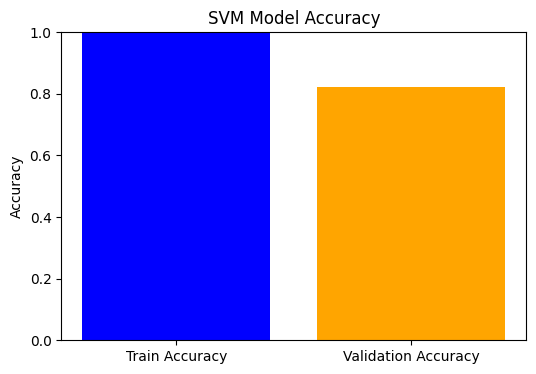

In [27]:
# Memprediksi pada data pelatihan dan validasi
y_train_pred_svm = svm_model.predict(X_train)
y_val_pred_svm = svm_model.predict(X_val)

# Menghitung akurasi
train_accuracy_svm = accuracy_score(y_train_1d, y_train_pred_svm)
val_accuracy_svm = accuracy_score(y_val_1d, y_val_pred_svm)

# Visualisasi akurasi
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_accuracy_svm, val_accuracy_svm], color=['blue', 'orange'])
plt.title('SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

SVM Classification Report:
                       precision    recall  f1-score   support

            cataract       0.78      0.84      0.81       203
diabetic_retinopathy       0.99      0.99      0.99       203
            glaucoma       0.68      0.70      0.69       193
              normal       0.83      0.76      0.79       245

            accuracy                           0.82       844
           macro avg       0.82      0.82      0.82       844
        weighted avg       0.82      0.82      0.82       844



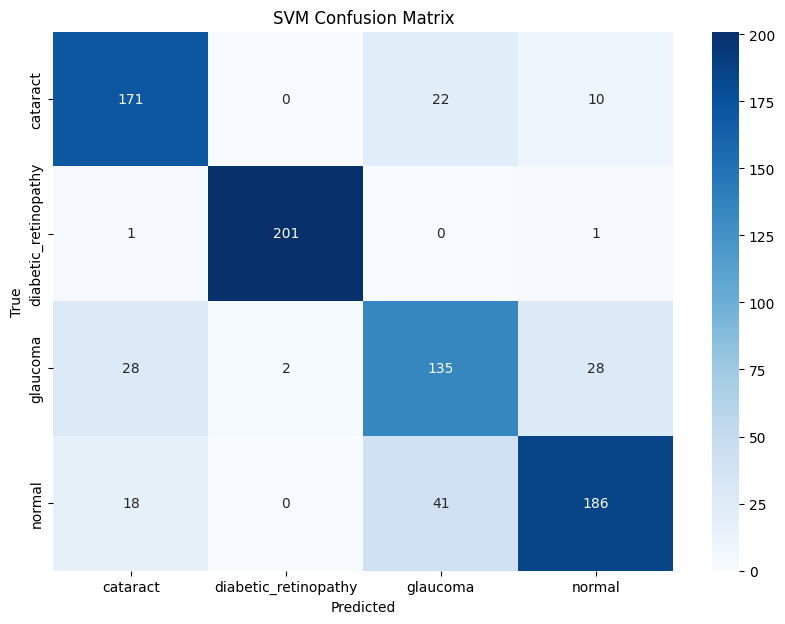

In [28]:
# Menghitung classification report
print("SVM Classification Report:\n", classification_report(y_val_1d, y_val_pred_svm, target_names=lb.classes_))

# Menghitung confusion matrix
cm_svm = confusion_matrix(y_val_1d, y_val_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

In [29]:
# Prediksi probabilitas
y_pred_proba_svm = svm_model.predict_proba(X_val)

# Hitung AUC (One-vs-Rest)
auc_svm = roc_auc_score(y_val_1d, y_pred_proba_svm, multi_class='ovr')
print(f"AUC for SVM: {auc_svm}")

AUC for SVM: 0.958090054539799


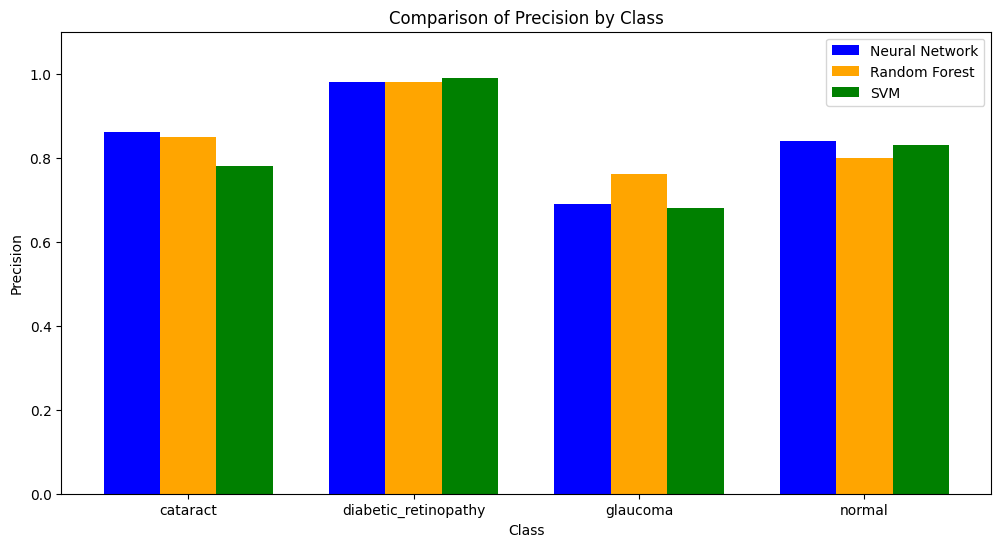

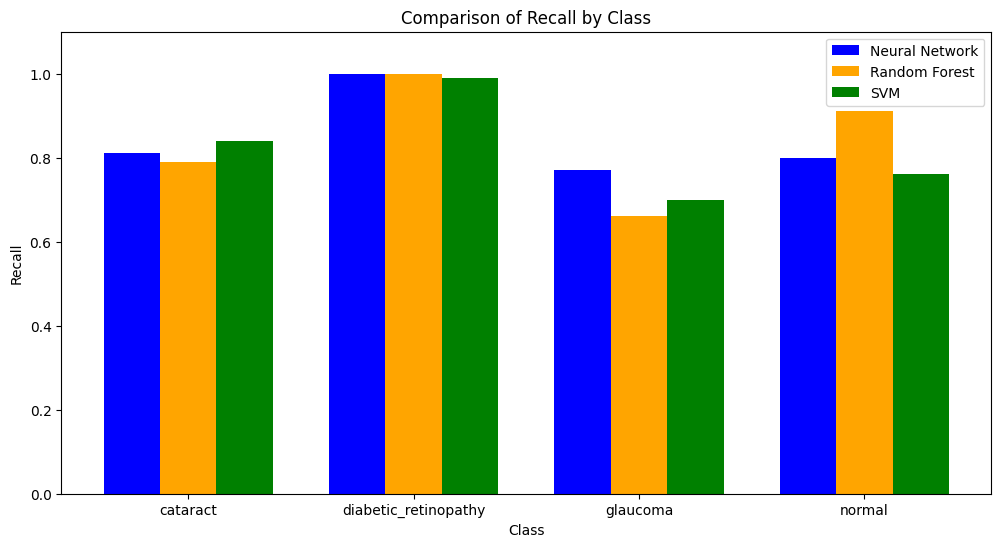

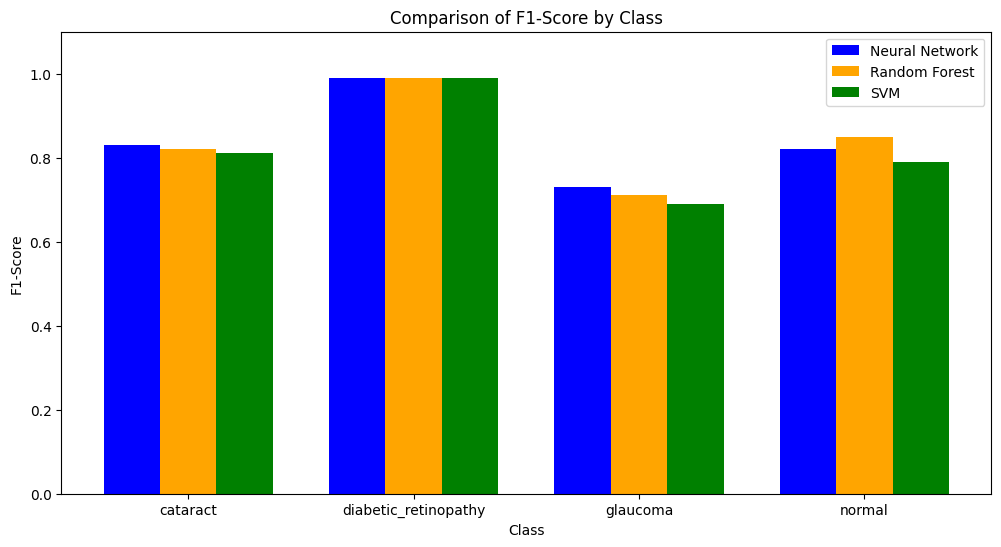

In [33]:
# Data metrik untuk setiap model
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
models = ['Neural Network', 'Random Forest', 'SVM']

# Precision
nn_precision = [0.86, 0.98, 0.69, 0.84]
rf_precision = [0.85, 0.98, 0.76, 0.80]
svm_precision = [0.78, 0.99, 0.68, 0.83]

# Recall
nn_recall = [0.81, 1.00, 0.77, 0.80]
rf_recall = [0.79, 1.00, 0.66, 0.91]
svm_recall = [0.84, 0.99, 0.70, 0.76]

# F1-Score
nn_f1 = [0.83, 0.99, 0.73, 0.82]
rf_f1 = [0.82, 0.99, 0.71, 0.85]
svm_f1 = [0.81, 0.99, 0.69, 0.79]

# Fungsi untuk plot metrik
def plot_metric_comparison(metric_name, nn_metric, rf_metric, svm_metric):
    x = np.arange(len(classes))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, nn_metric, width, label='Neural Network', color='blue')
    plt.bar(x, rf_metric, width, label='Random Forest', color='orange')
    plt.bar(x + width, svm_metric, width, label='SVM', color='green')

    plt.xlabel('Class')
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name} by Class')
    plt.xticks(x, classes)
    plt.ylim(0, 1.1)
    plt.legend(loc='upper right')
    plt.show()

# Plot Precision
plot_metric_comparison('Precision', nn_precision, rf_precision, svm_precision)

# Plot Recall
plot_metric_comparison('Recall', nn_recall, rf_recall, svm_recall)

# Plot F1-Score
plot_metric_comparison('F1-Score', nn_f1, rf_f1, svm_f1)

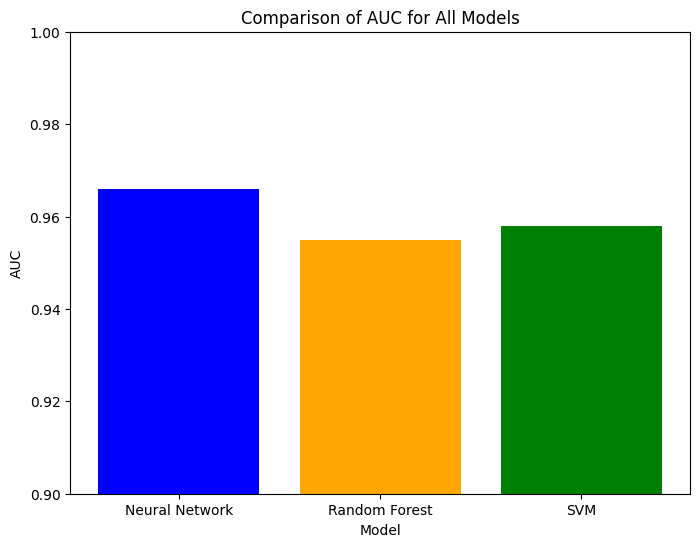

In [34]:
# Data AUC
auc_values = [0.966, 0.955, 0.958]  # AUC untuk Neural Network, Random Forest, SVM

# Plot
plt.figure(figsize=(8, 6))
plt.bar(models, auc_values, color=['blue', 'orange', 'green'])

plt.xlabel('Model')
plt.ylabel('AUC')
plt.title('Comparison of AUC for All Models')
plt.ylim(0.9, 1.0)
plt.show()

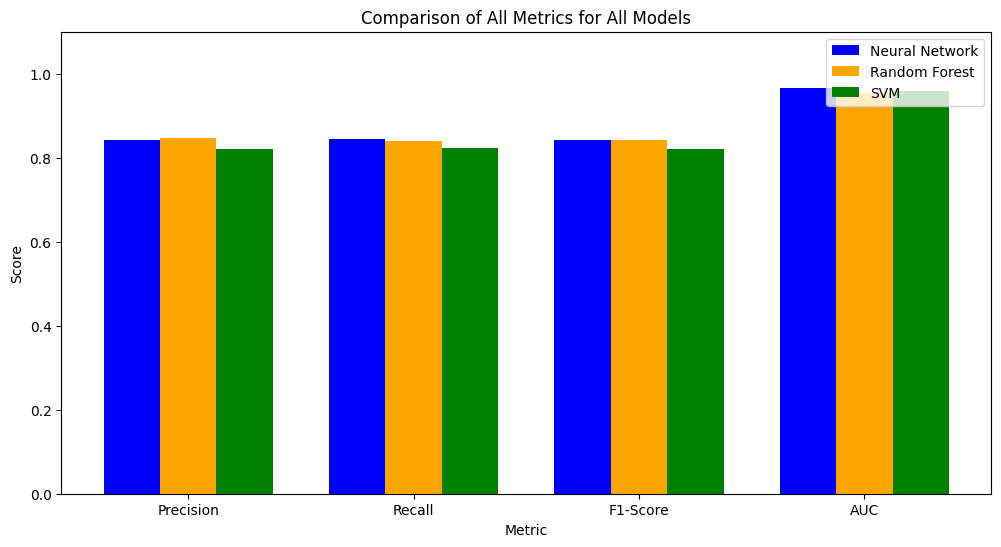

In [35]:
# Data gabungan
metrics = ['Precision', 'Recall', 'F1-Score', 'AUC']
nn_metrics = [np.mean(nn_precision), np.mean(nn_recall), np.mean(nn_f1), auc_values[0]]
rf_metrics = [np.mean(rf_precision), np.mean(rf_recall), np.mean(rf_f1), auc_values[1]]
svm_metrics = [np.mean(svm_precision), np.mean(svm_recall), np.mean(svm_f1), auc_values[2]]

# Plot
x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, nn_metrics, width, label='Neural Network', color='blue')
plt.bar(x, rf_metrics, width, label='Random Forest', color='orange')
plt.bar(x + width, svm_metrics, width, label='SVM', color='green')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Comparison of All Metrics for All Models')
plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.legend(loc='upper right')
plt.show()

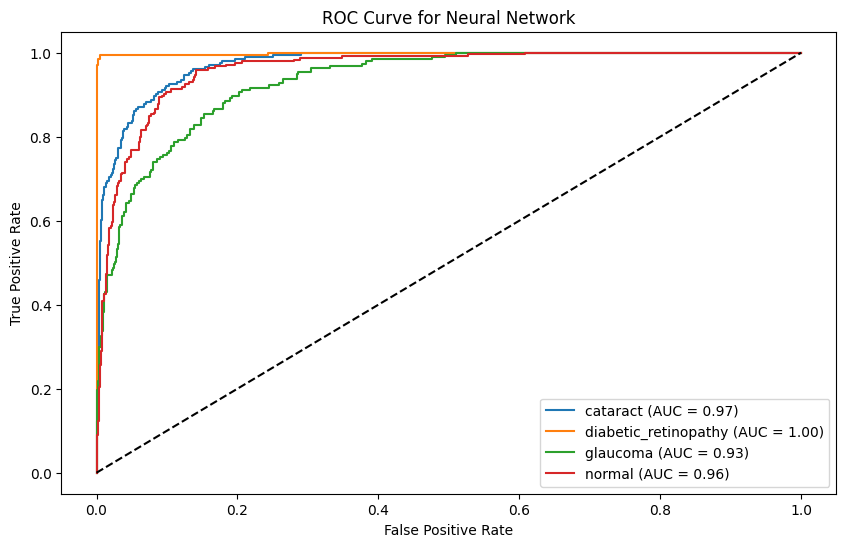

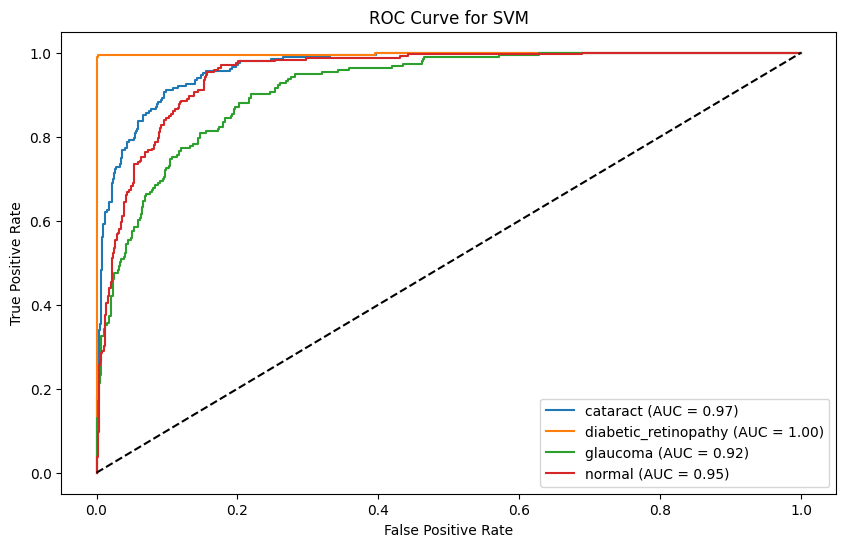

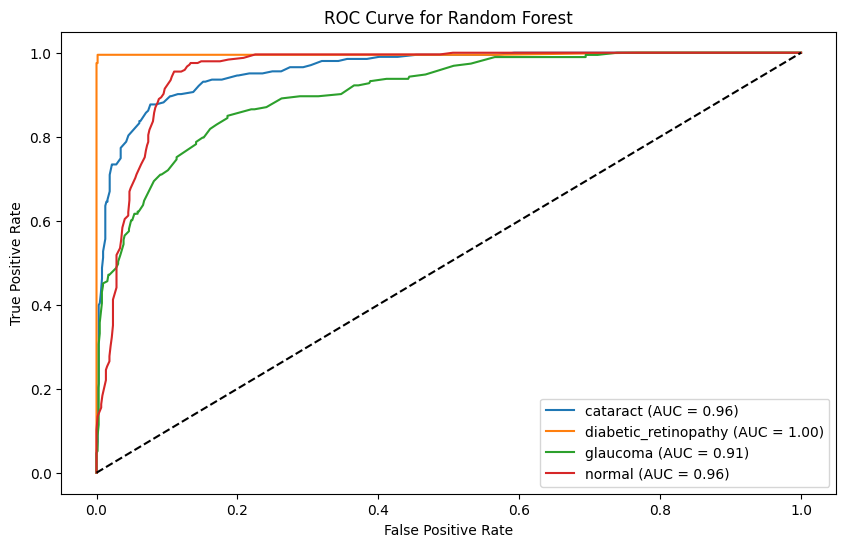

In [32]:
# Fungsi untuk plot ROC Curve
def plot_roc_curve(y_true, y_pred_proba, classes, model_name):
    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC Curve untuk setiap model
plot_roc_curve(y_val, y_pred_proba_nn, lb.classes_, 'Neural Network')
plot_roc_curve(y_val, y_pred_proba_svm, lb.classes_, 'SVM')
plot_roc_curve(y_val, y_pred_proba_rf, lb.classes_, 'Random Forest')